In [47]:
import json
import os
from collections import defaultdict
import fiftyone as fo
import fiftyone.utils.random as four
from PIL import Image
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

In [4]:
DATASET_ROOT = '/media/datasets/DATASET'
FRAMES_ROOT = os.path.join(DATASET_ROOT, 'FRAMES')
DATASET_CFG_PATH = 'metadata/set_utf.cfg'
IMG_WIDTH = 960
IMG_HEIGHT = 600
device = "cuda"

In [ ]:
sam = sam_model_registry["default"](checkpoint="../sam_vit_h_4b8939.pth")
sam.to(device=device)
predictor = SamPredictor(sam)

In [5]:
dataset_dict = defaultdict(list)

with open(os.path.join(DATASET_ROOT, DATASET_CFG_PATH), 'r') as fd:
    fname = ''
    for line in fd:
        # print(line)
        line = line.strip()
        if line.split('.')[-1] == 'frame':
            fname = os.path.join(FRAMES_ROOT, *line.split('\\'))
            fname = fname.replace('.frame', '.bmp')
            # print(fname)
            # print(os.path.isfile(os.path.join(FRAMES_ROOT, fname)))
        else:
            # fill objects info
            x_px, y_px, cls = list(map(int, line.replace(' ', '').split(',')))
            x = x_px / IMG_WIDTH
            y = y_px / IMG_HEIGHT
            dataset_dict[fname].append({'x': x, 'y': y, 'x_px': x_px, 'y_px': y_px, 'cls': cls})

In [6]:
dataset_dict['/media/datasets/DATASET/FRAMES/0/1538/frame0006.bmp']

[{'x': 0.8427083333333333, 'y': 0.56, 'x_px': 809, 'y_px': 336, 'cls': 3},
 {'x': 0.6260416666666667,
  'y': 0.49833333333333335,
  'x_px': 601,
  'y_px': 299,
  'cls': 0}]

In [7]:
dataset = fo.Dataset.from_images_dir(
    images_dir=FRAMES_ROOT,
    name='hackatom',
    overwrite=True
    )
dataset.persistent = True
session = fo.launch_app(dataset, address="0.0.0.0")

  26% |███------------| 2047/7808 [217.6ms elapsed, 612.5ms remaining, 9.4K samples/s] 

 100% |███████████████| 7808/7808 [904.9ms elapsed, 0s remaining, 8.6K samples/s]      


In [8]:
preds_view = dataset.take(len(dataset))

In [9]:
with fo.ProgressBar() as pb:
    for sample in pb(preds_view):
        if sample.filepath in dataset_dict.keys():
            keypoints = []
            detections = []
            predictor.set_image(cv2.imread(sample.filepath))
            for kp in dataset_dict[sample.filepath]:
                # Add keypoints
                keypoints.append(
                    fo.Keypoint(
                        label=str(kp['cls']),
                        points=[(kp['x'], kp['y'])],
                    )
                )
                # Add segmentation
                pts = [kp['x_px'], kp['y_px']]
                masks, _, _ = predictor.predict(point_coords=np.array([pts]), 
                                point_labels=np.array([1]), 
                                multimask_output=True)
                bbox = np.argmax
                detections.append(
                    fo.Detection(
                        label=kp['cls'],
                        bounding_box=[],
                        mask=masks[0],
                        confidence=0.96,
                    )
                )
            sample['keypoints'] = fo.Keypoints(keypoints=keypoints)
            sample.save()

   0% ||--------------|    0/7808 [24.0ms elapsed, ? remaining, ? samples/s] 

 100% |███████████████| 7808/7808 [11.6s elapsed, 0s remaining, 613.7 samples/s]      


In [35]:

predictor.set_image(cv2.imread(sample.filepath))

masks, _, _ = predictor.predict(point_coords=np.array([[150, 150]]), point_labels=np.array([0]))

In [36]:
pts = sample.keypoints['keypoints'][0]['points'][0] * np.array(Image.open(sample.filepath).size)
cls = sample.keypoints['keypoints'][0]['label']
masks, _, _ = predictor.predict(point_coords=np.array([pts]), 
                                point_labels=np.array([1]), 
                                multimask_output=True)

In [37]:
masks[:1].shape

(1, 600, 960)

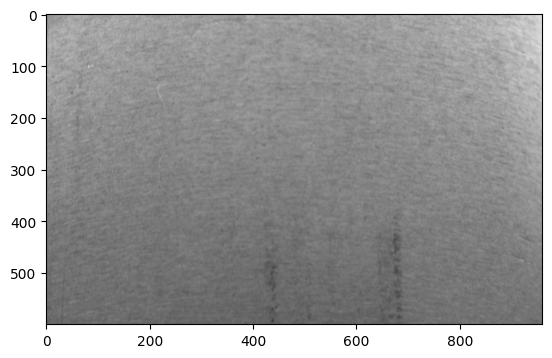

In [38]:
image = cv2.imread(sample.filepath)
plt.imshow(image)

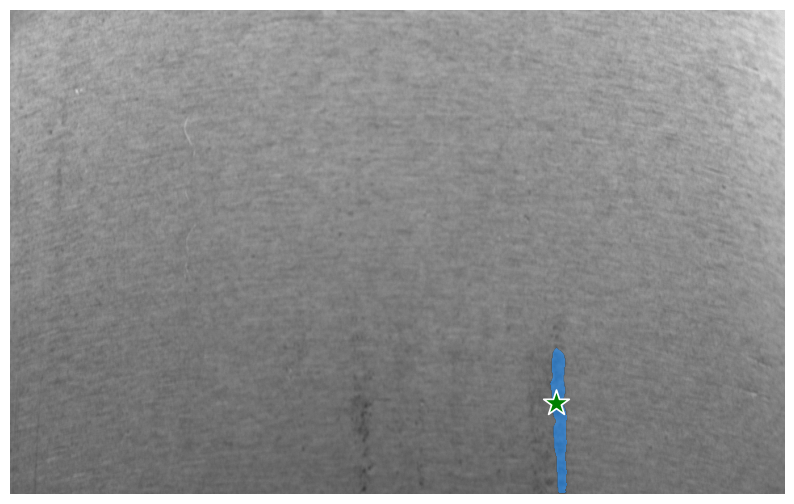

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[0:1], plt.gca())
show_points(pts, 1, plt.gca())
plt.axis('off')
plt.show() 

In [46]:
cv2.boundingRect(masks[0])

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'boundingRect'
> Overload resolution failed:
>  - array data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'array'
